In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import seaborn as sns

## Read in merged weather / taxi data

In [2]:
chunklist = []
for chunk in pd.read_csv('data_merged.csv', chunksize = 100000):
    chunklist.append(chunk)

In [3]:
df = pd.concat(chunklist)

In [4]:
df.head()

,pickup,dropoff,trip_distance,trip_time,speed,tempm,precipm,precip_type,id
0,2016-02-05 00:00:00,2016-02-05 00:08:02,1.5,0 days 00:08:02.000000000,11.203320,6.7,0.0,clear,0
1,2016-02-05 00:00:01,2016-02-05 00:14:36,3.0,0 days 00:14:35.000000000,12.342857,6.7,0.0,clear,0
2,2016-02-05 00:00:02,2016-02-05 00:21:48,4.0,0 days 00:21:46.000000000,11.026034,6.7,0.0,clear,0
3,2016-02-05 00:00:02,2016-02-05 00:02:20,0.9,0 days 00:02:18.000000000,23.478261,6.7,0.0,clear,0
4,2016-02-05 00:00:03,2016-02-05 00:05:17,0.6,0 days 00:05:14.000000000,6.878981,6.7,0.0,clear,0


In [5]:
df['pickup'] = pd.to_datetime(df['pickup'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684583 entries, 0 to 1684582
Data columns (total 9 columns):
pickup           1684583 non-null datetime64[ns]
dropoff          1684583 non-null object
trip_distance    1684583 non-null float64
trip_time        1684583 non-null object
speed            1684583 non-null float64
tempm            1684583 non-null float64
precipm          1684583 non-null float64
precip_type      1684583 non-null object
id               1684583 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 115.7+ MB


## Explore the taxi/weather data by precip_type

In [7]:
df_grouped = df.groupby('precip_type')

In [8]:
rain = df_grouped.get_group('rain')
snow = df_grouped.get_group('snow')
clear = df_grouped.get_group('clear')

## Scatter plot of trip distances vs speeds with the precipitation
### Using the color map, we can see that the darker dots (higher precipitation) are more concentrated at the lower speeds

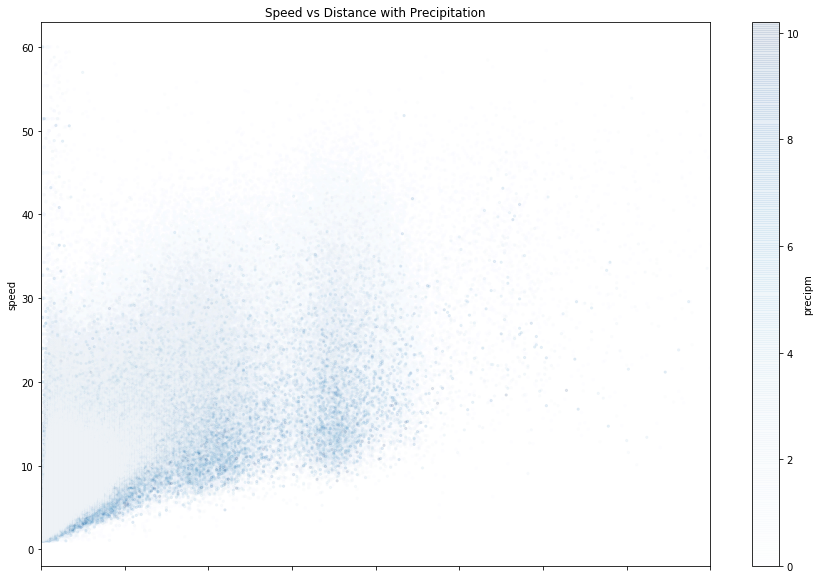

In [35]:
df.plot(kind = 'scatter', x = 'trip_distance',y = 'speed', c = 'precipm', s = 5, colormap = 'Blues', 
        figsize = (15,10), title = 'Speed vs Distance with Precipitation', xlim = (0,40), alpha = 0.1)
plt.xlabel('trip_distance')
plt.show()

## Scatterplot of speed vs distance with the temperature
### Unsure if there is a clear pattern here

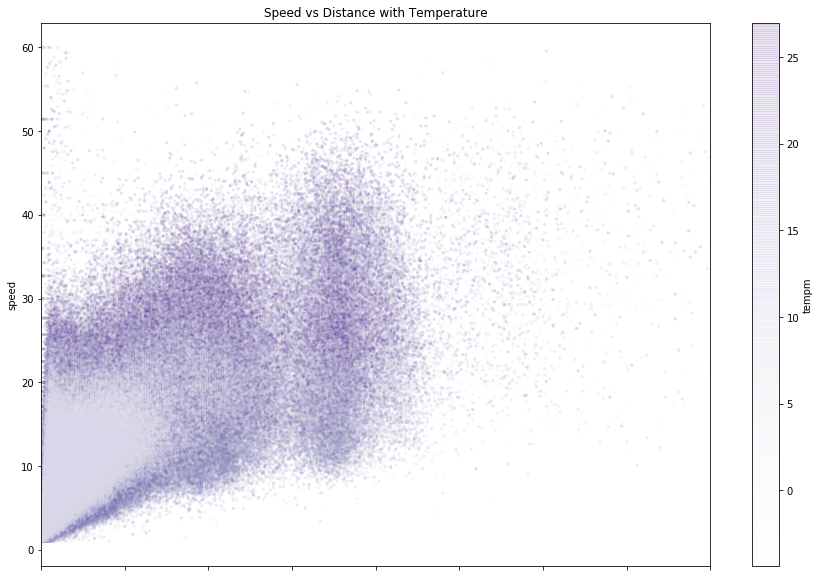

In [33]:
df.plot(kind = 'scatter', x = 'trip_distance',y = 'speed', c = 'tempm', s = 5, colormap = 'Purples', 
        figsize = (15,10), title = 'Speed vs Distance with Temperature', xlim = (0,40), alpha = 0.1)
plt.show()

## Distribution of speeds for days of rain, snow and clear days

In [11]:
def data_plots(x,y):
    data_rain = rain[(rain['trip_distance'] >= x) & (rain['trip_distance'] <=y)]
    data_clear = clear[(clear['trip_distance'] >= x) & (clear['trip_distance'] <= y)]
    data_snow = snow[(snow['trip_distance'] >= x) & (snow['trip_distance'] <= y)]
    plt.figure(figsize = (12,10))
    plt.title('Speed Distribution for Distances Between '+ str(x) + ' and '+ str(y) + ' miles')
    kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True)
    sns.distplot(data_rain['speed'], kde = True, hist = False, label = 'rain')
    sns.distplot(data_snow['speed'], kde = True, hist = False, label = 'snow')
    sns.distplot(data_clear['speed'], kde = True, hist = False, label = 'clear')
    plt.legend()


## Plot the distribution of speeds across all trip distances.

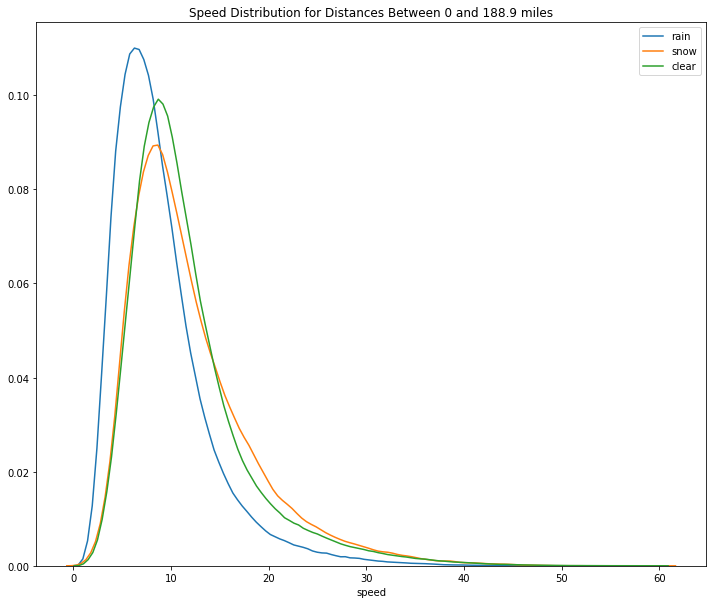

In [12]:
data_plots(0, df.trip_distance.max())

### We can see that the speed distribution for when it rains tends to be less than when it is clear / snowing

## Maybe the distributions change for different trip distances?
## Plots of speed distributions for different distance.

In [13]:
df.trip_distance.describe()

count    1.684583e+06
mean     2.853695e+00
std      3.588965e+00
min      1.000000e-01
25%      1.000000e+00
50%      1.600000e+00
75%      3.000000e+00
max      1.889000e+02
Name: trip_distance, dtype: float64

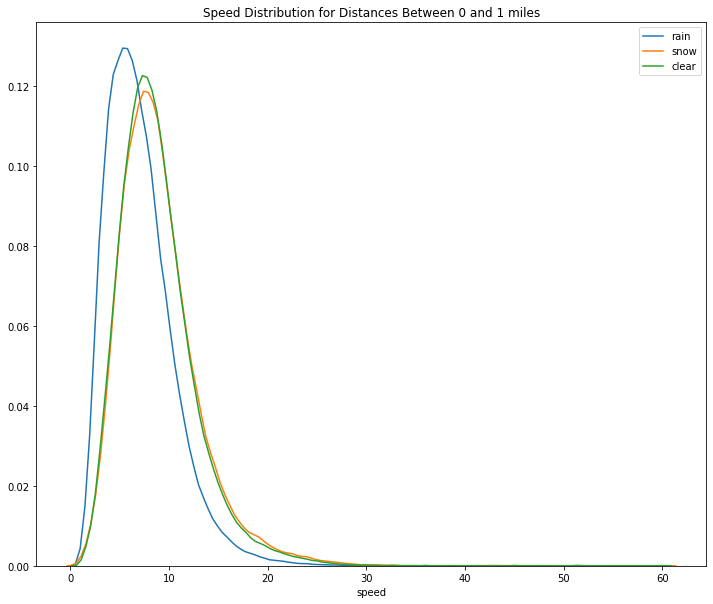

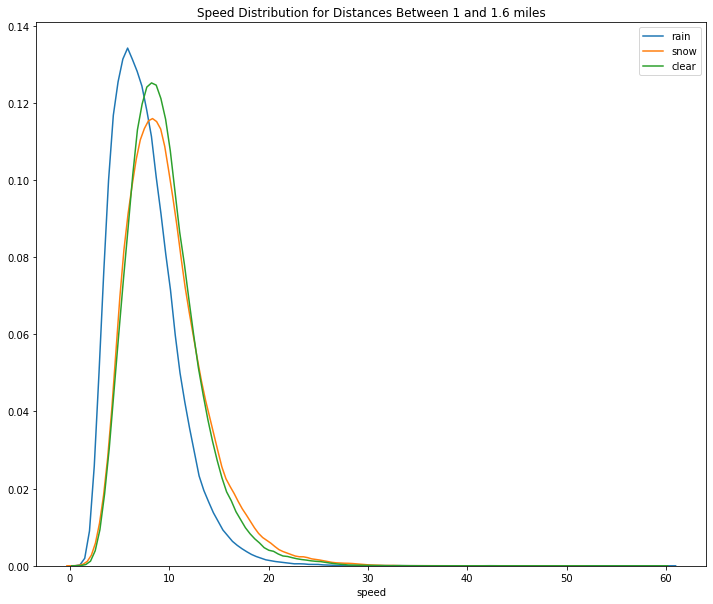

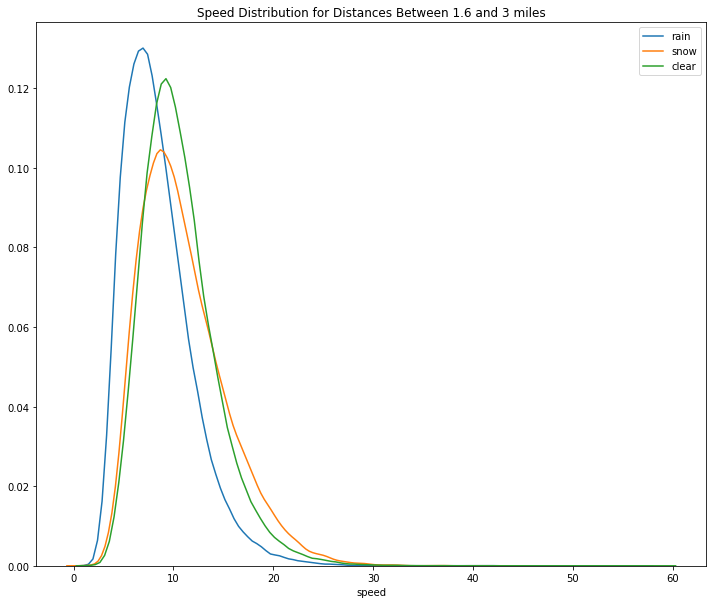

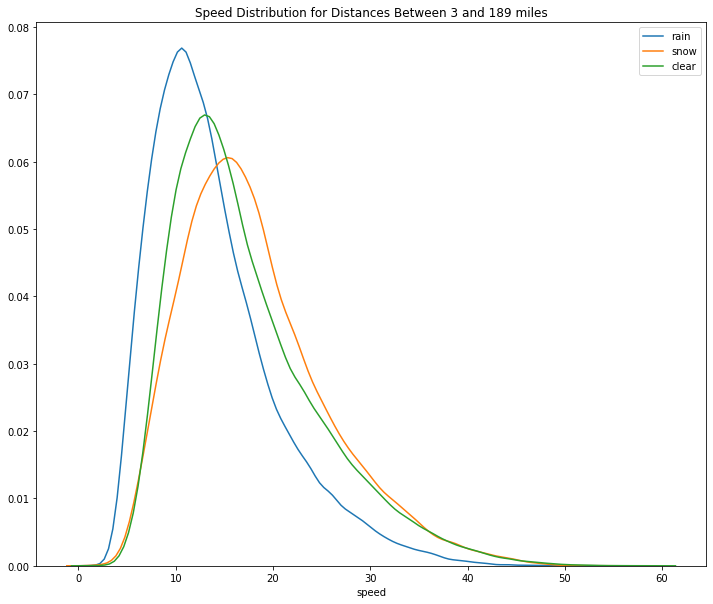

In [14]:
data_plots(0,1)
data_plots(1,1.6)
data_plots(1.6,3)
data_plots(3,189)


### We can see that for rainy days, the speed distribution is consistently lower than when it is clear / snowing

### Distribution of Trip Distances for days of rain, snow, and clear days

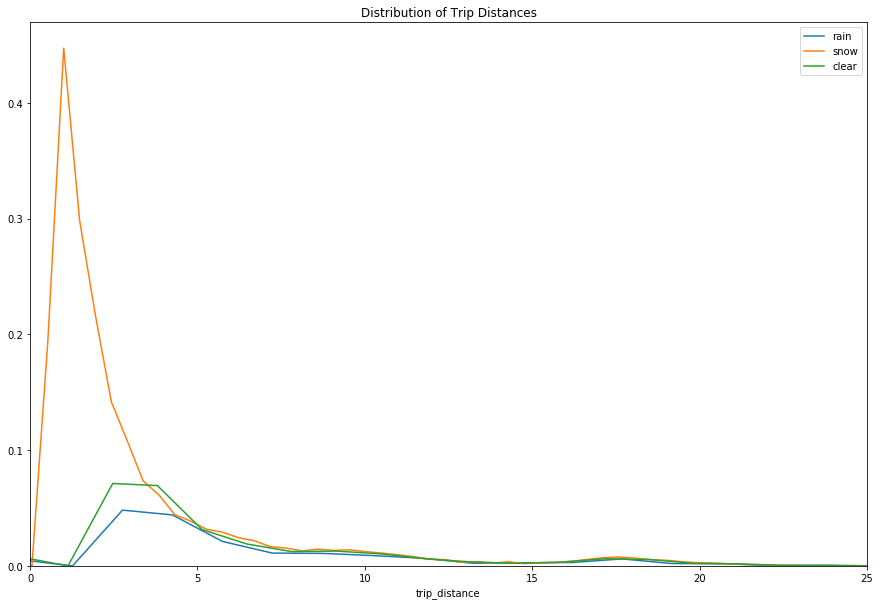

In [15]:
#plot distributions of travel distances for rain days, snow days, and clear days

plt.figure(figsize = (15,10))
plt.xlim(0,25)
plt.title('Distribution of Trip Distances')
sns.distplot(rain['trip_distance'], kde = True, hist = False, label = 'rain')
sns.distplot(snow['trip_distance'], kde = True, hist = False, label = 'snow')
sns.distplot(clear['trip_distance'], kde = True, hist = False, label = 'clear')


### Here we can see that when it snows, most of the distances will be smaller when compared to rainy or clear days.

## Let's see the number of taxi trips per hour of the day

In [16]:
days = [(11,29), (2,24), (5,3), (10,27), (3,4), (2,5), (3,21), (12,17), (7,2), (9,12)]

In [17]:
days.sort()

In [36]:
def plot_hourly(d, data):
    total_counts = []
    for i in d:
        temp_list = []
        df_grouped_day = data.groupby([data.pickup.dt.month, data.pickup.dt.day])
        date = df_grouped_day.get_group(i)
        for h in range(0,24):
            temp_list.append(len(date.groupby(date.pickup.dt.hour).get_group(h)))
        total_counts.append(temp_list)
    df_counts = pd.DataFrame(total_counts).T
    df_counts.plot(title = 'Number of Taxi Trips per Hour', figsize = (10,5))
    plt.xticks(range(1,24, 1))
    plt.xlabel('hours')
    plt.ylabel('# of trips')
    plt.grid()
    plt.legend(d)
    plt.show()

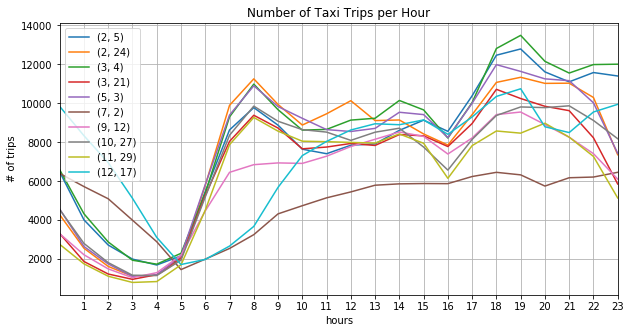

In [37]:
plot_hourly(days, df)

In [38]:
raindays = [(11,29), (2,24), (5,3), (10,27)]
raindays.sort()
snowdays = [(3,4), (2,5), (3,21), (12,17)]
snowdays.sort()
cleardays = [(7,2), (9,12)]
cleardays.sort()

## Maybe the hourly for rain days and snow days will differ from clear days.

### Rain days

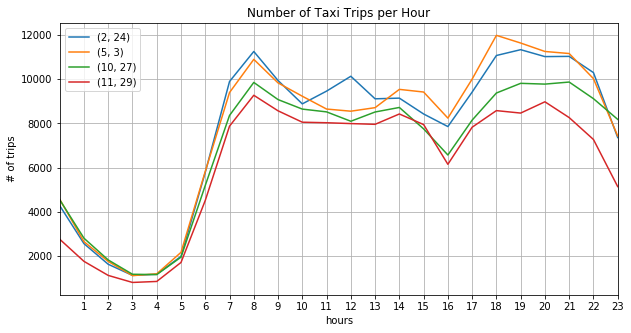

In [39]:
plot_hourly(raindays, df)

### Snow days

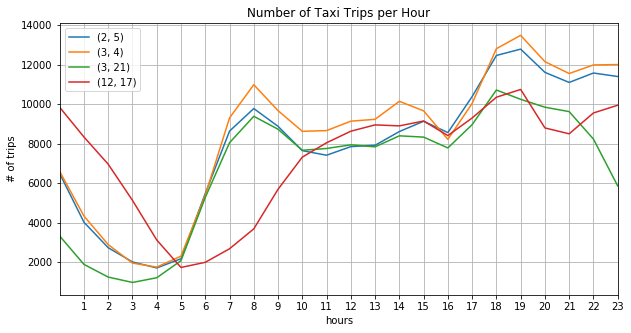

In [40]:
plot_hourly(snowdays,df)


### Clear days

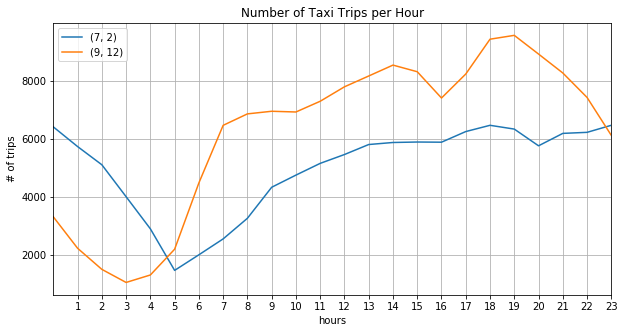

In [41]:
plot_hourly(cleardays,df)

## It does not seem like there is a clear difference in the patterns of rainy, snowy, and clear days in terms of the number of taxi trips per hour.

<function matplotlib.pyplot.show(*args, **kw)>

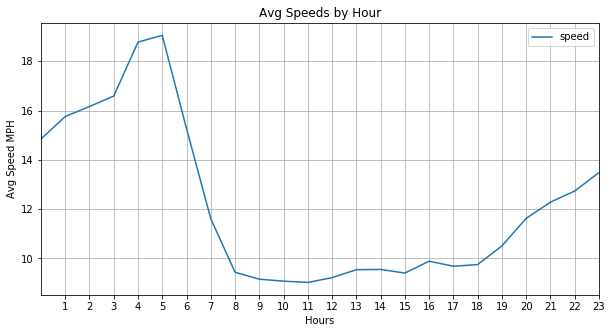

In [62]:
df.groupby(df.pickup.dt.hour).agg({'speed':'mean'}).plot(title = 'Avg Speeds by Hour', figsize = (10,5))
plt.xlabel('Hours')
plt.ylabel('Avg Speed MPH')
plt.xticks(range(1,24, 1))
plt.grid()
plt.show
